<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# *Capstone Project*
# Title - Sentiment Analysis of Earnings Calls to Predict Bankruptcy
*
By: Stephanie Nduaguba

## Dataset Overview
The dataset, derived from the "Seeking Alpha" website, underpins research on predicting firm bankruptcy through earnings call data, as explored in the study "Predicting bankruptcy of firms using earnings call data and transfer learning." It encompasses earnings call details for 1,016 companies spanning 2008 to 2020, meticulously pre-processed and structured. The dataset features three key components:

- **Title**: Incorporates the company's name, along with the date, quarter, and time of the earnings call.
- **Text**: Contains the detailed transcripts of the earnings calls, serving as the feature variable.
- **Label**: Designates the company's financial status, with '0' indicating non-bankrupt and '1' indicating bankrupt companies, serving as the target variable.

Data was manually verified against Google search results to ascertain each company's bankruptcy status, identifying 311 bankrupt and 705 non-bankrupt companies among the sample.

For an in-depth exploration of the research and findings, refer to the source article: [Predicting bankruptcy of firms using earnings call data and transfer learning](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10280182/).

## Goals & Objectives
1. Craft a Smarter Framework for Bankruptcy Prediction - Blends traditional finance numerical data with sentiment analysis for more efficiently.2. Decode the Emotions in Limited Financial Numerical Data Scenarios - Uses sentiments to fill in the gaps where hard numbers may not tell the full story.
3. Inform Stakeholders - Provides our stakeholders with data-driven guidance, helping them steer clear of financial pitfalls.




### Import libraries and modules

In [27]:
# Import libraries and modules for numerical operations and data manipulation
import numpy as np
import pandas as pd
from random import sample

# Import libraries and modules for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from wordcloud import WordCloud

# Import NLP module for text processing
import spacy

# Import modules and functions for modeling
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Binarizer, binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score, make_scorer, f1_score
from sklearn import metrics

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import KMeansSMOTE, SMOTE

# Import other modules
import re
import warnings
sns.set_style("whitegrid")
%matplotlib inline

### Read and inspect data
- Read the data.
- Perform some basic structural cleaning.
- Review the class distribution in the dataset.

In [2]:
# Import and load dataset
excel = '/Users/stephanienduaguba/Documents/DSI Files/Capstone Project/EarningsCalls_data_2007-2021.xlsx'
df = pd.read_excel(excel)

# Drop the 'Unnamed' and 'filename' columns
df.drop(['Unnamed: 0', 'filename'], axis=1, inplace=True)

# Rename the 'Label' column to 'label'
df.rename(columns={'Label': 'label'}, inplace=True)

# Display a random sample of 5 rows
df.sample(n=5, random_state=42)

title  \
753  Itron, Inc. (ITRI) Q1 2009 Earnings Call Trans...   
519  The Williams Companies, Inc. (NYSE:WMB) 2020 W...   
210  Ashford Hospitality Trust (NYSE:AHT) Q4 2007 E...   
943  Comfort Systems USA Q4 2007 Earnings Call Febr...   
915  PHH Corp. (NYSE:PHH) Q4 2007 Earnings Call Feb...   

                                                  text  label  
753   Steve Sanders – Stephens Inc.  John Quealy – ...      0  
519   Praneeth Satish  Okay, good afternoon. And th...      1  
210   Harry Sullivan – Senior Vice President and Pr...      0  
943   Matt Duncan – Stephens, Inc  David Yuschak - ...      0  
915   Jordan Hymowitz - Philadelphia Financial  Gab...      1

In [3]:
# Display transcript before cleaning and pre-processing
print(df['text'].iloc[0])

 Operator  Justin Clare - ROTH Capital Partners  Hello, ladies and gentlemen, this is Ivan. I will be the operator for this conference call. I  would like to welcome everyone to Yingli Green Energy Holding Company Limited’s  Third Quarter 2017 Financial Results Conference Call.  All lines have been placed on mute to prevent background noise. After today’s  presentation, there will be a question-and-answer session. Please follow the instructions  given at that time if you would like to ask a question.  https://seekingalpha.com/article/4132770-yingli-green-energy-yge-q3-2017-results-earnings-call-transcript  1/13   12/4/21, 8:16 PM  Yingli Green Energy (YGE) Q3 2017 Results - Earnings Call Transcript | Seeking Alpha  Now, I would like to transfer the call to the host for today’s call, Mr. Pengsong Yuan,  General Counsel of Yingli Green Energy. Mr. Yuan, please proceed.  Pengsong Yuan  Thank you everyone, and thank you operator, and thank you everyone, for joining us  today for Yingli’s t

In [4]:
# Dictionary mapping numerical labels to text labels
label_to_sentiment = {0: "Non-Bankrupt", 1: "Bankrupt"}

# Function that decodes numerical labels to text
def label_decoder(label):
    # Return the corresponding text label for a given numerical label
    return label_to_sentiment[label]

# Apply the label_decoder function to each element in the 'label' column
# Store the results in a new 'sentiment' column in the DataFrame
df['sentiment'] = df['label'].apply(lambda x: label_decoder(x))

# Display a random sample of 5 rows
df.sample(n=5, random_state=42)

title  \
753  Itron, Inc. (ITRI) Q1 2009 Earnings Call Trans...   
519  The Williams Companies, Inc. (NYSE:WMB) 2020 W...   
210  Ashford Hospitality Trust (NYSE:AHT) Q4 2007 E...   
943  Comfort Systems USA Q4 2007 Earnings Call Febr...   
915  PHH Corp. (NYSE:PHH) Q4 2007 Earnings Call Feb...   

                                                  text  label     sentiment  
753   Steve Sanders – Stephens Inc.  John Quealy – ...      0  Non-Bankrupt  
519   Praneeth Satish  Okay, good afternoon. And th...      1      Bankrupt  
210   Harry Sullivan – Senior Vice President and Pr...      0  Non-Bankrupt  
943   Matt Duncan – Stephens, Inc  David Yuschak - ...      0  Non-Bankrupt  
915   Jordan Hymowitz - Philadelphia Financial  Gab...      1      Bankrupt

In [5]:
# Display the number of rows and columns
df.shape

(1016, 4)

In [6]:
# Display the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      1016 non-null   object
 1   text       1016 non-null   object
 2   label      1016 non-null   int64 
 3   sentiment  1016 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.9+ KB


In [7]:
# Count of each unique value in the 'sentiment' column
sentiment_counts = df['sentiment'].value_counts()

# Percentage of each unique value in the 'sentiment' column
sentiment_percentages = df['sentiment'].value_counts(normalize=True) * 100

# Combine the counts and percentages into one DataFrame for a comprehensive view
sentiment_summary = pd.DataFrame({
    'Counts': sentiment_counts,
    'Percentage': sentiment_percentages
})

# Display the result
print(sentiment_summary)

              Counts  Percentage
sentiment                       
Non-Bankrupt     705   69.389764
Bankrupt         311   30.610236


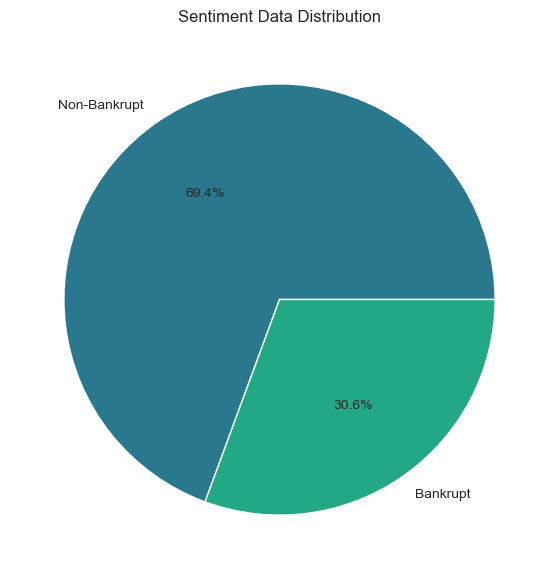

In [8]:
# Sentiment data distribution plot
# Calculate counts of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Define custom colors for the pie chart
colors = ['#2A788EFF','#22A884FF']

# Create a pie chart
plt.figure(figsize=(14, 7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors)

# Add a title
plt.title("Sentiment Data Distribution")

# Display the pie chart
plt.show()

*The dataset comprises transcripts from earnings calls of various companies, sourced from the Seeking Alpha website. Initial analysis reveals that the dataset is skewed, predominantly featuring transcripts from non-bankrupt firms, a common characteristic for datasets of this nature. The data is complete, with no missing entries noted. However, it requires some text pre-processing to be suitable for analysis through an NLP (Natural Language Processing) pipeline. The subsequent section outlines the preliminary pre-processing steps undertaken on the dataset before its introduction into the NLP workflow.*

### Pre-process text
- Lowercase: Convert all characters in the text to lowercase to ensure uniformity.
- Remove URLs: Find and remove all URLs. This applies to URLs starting with http://, https://, and www..
- Remove mentions: Remove Twitter-style mentions (e.g., @username).
- Remove numerical data: Remove standalone numbers and words connected to numbers (useful for removing dates like 20th, 31st, and monetary amounts).
- Remove punctuation: Keep only letters and spaces (and end-of-sentence punctuations).
- Remove extra spaces: Replaces multiple spaces with a single space and removes leading and trailing spaces.

In [ ]:
# Function to normalize and clean text using regular expressions
def clean_text(text):
    # Normalize by lowercasing
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?:\/\/\S+|www\.\S+', '', text)
    
    # Remove mentions (like Twitter handles)
    text = re.sub(r'@\w+', '', text)
    
    # Remove numerical data (like money, dates)
    # This regex removes numbers and words directly connected to numbers (e.g., dates like 20th)
    text = re.sub(r'\b\d+\S*|\S*\d+\b', '', text)
    
    # Remove punctuation (keep only letters and spaces, and end-of-sentence punctuations)
    text = re.sub(r'[^a-z\s.!?]', '', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [10]:
# Apply clean_text function to each entry in the 'text' column
df['text'] = df['text'].apply(lambda x: clean_text(x))

# Display a random sample of 5 rows
df.sample(n=5, random_state=42)

title  \
753  Itron, Inc. (ITRI) Q1 2009 Earnings Call Trans...   
519  The Williams Companies, Inc. (NYSE:WMB) 2020 W...   
210  Ashford Hospitality Trust (NYSE:AHT) Q4 2007 E...   
943  Comfort Systems USA Q4 2007 Earnings Call Febr...   
915  PHH Corp. (NYSE:PHH) Q4 2007 Earnings Call Feb...   

                                                  text  label     sentiment  
753  steve sanders stephens inc. john quealy canacc...      0  Non-Bankrupt  
519  praneeth satish okay good afternoon. and thank...      1      Bankrupt  
210  harry sullivan senior vice president and princ...      0  Non-Bankrupt  
943  matt duncan stephens inc david yuschak smh cap...      0  Non-Bankrupt  
915  jordan hymowitz philadelphia financial gabriel...      1      Bankrupt

In [11]:
# Display transcript after cleaning and pre-processing
print(df['text'].iloc[0])

operator justin clare roth capital partners hello ladies and gentlemen this is ivan. i will be the operator for this conference call. i would like to welcome everyone to yingli green energy holding company limiteds third quarter financial results conference call. all lines have been placed on mute to prevent background noise. after todays presentation there will be a questionandanswer session. please follow the instructions given at that time if you would like to ask a question. pm yingli green energy yge results earnings call transcript seeking alpha now i would like to transfer the call to the host for todays call mr. pengsong yuan general counsel of yingli green energy. mr. yuan please proceed. pengsong yuan thank you everyone and thank you operator and thank you everyone for joining us today for yinglis third quarter financial results conference call. the third quarter earnings release was issued earlier today and available on the companys website at on the call today from yingli g

*Following initial pre-processing, the transcript text is now consistently lowercase. Unnecessary elements such as URLs, mentions, numbers, extraneous punctuation (except for sentence-ending punctuation), and additional spaces have been cleared using regex. The exclusion of numerical data is particularly relevant in a financial setting, as these figures often don't add value to sentiment analysis. With these preliminary cleaning steps completed, it's appropriate to move forward with exploratory data analysis (EDA) to gain deeper insights into the dataset.*

### EDA - Exploratory Data Analysis
- Visualize bankrupt and non-bankrupt data.
- Visualize Part-of-Speech (POS) tags of the transcript data to determine best featrure for sentiment analysis.
- Determine statistics on word lemmas (base form of a word) between the bankrupt and non-bankrupt classes, including: average length of each transcript; unique lemmas and diversity of the lemmas.

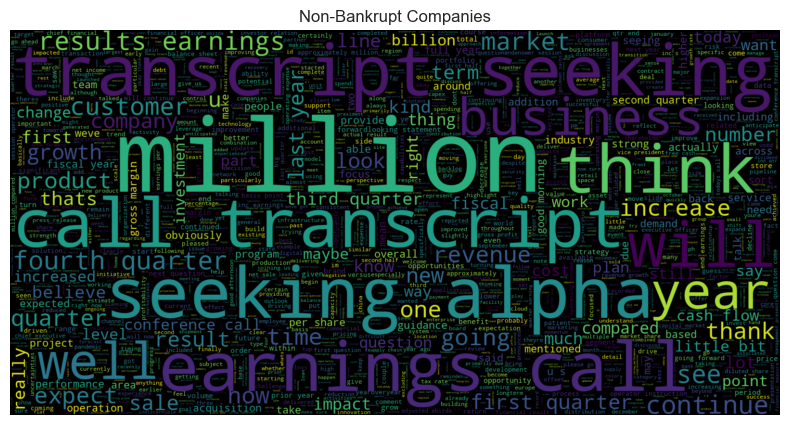

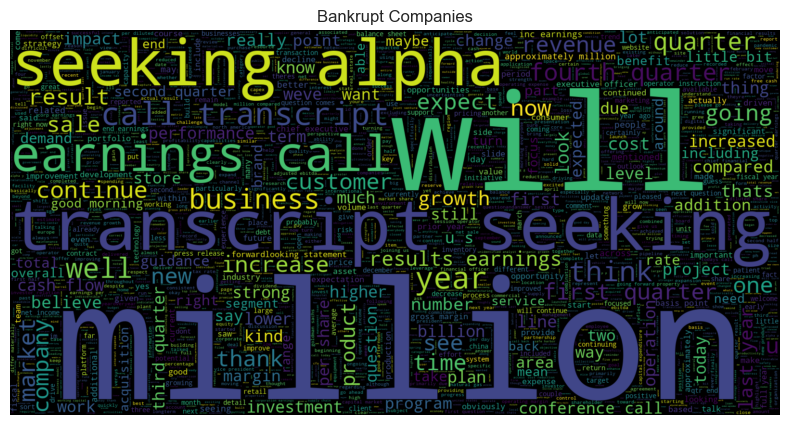

In [14]:
# Code to display wordcloud of non-bankrupt and bankrupt data
def display_wordcloud(df, label, title, max_words=5000, width=1600, height=800, fig_size=(10, 5)):
    # Prepare the data from DataFrame
    data = " ".join(df[df['label'] == label]['text'])

    # Create a WordCloud object with specified configurations
    wc = WordCloud(max_words=max_words, width=width, height=height, background_color='black')

    # Generate the word cloud from the text data
    wc.generate(data)

    # Set up the size of the figure
    plt.figure(figsize=fig_size)

    # Display the generated WordCloud image
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')  # Hide the axis
    
    # Display the title
    plt.title(title, fontsize=12)
    
    plt.show()  # Display the figure

# Display wordcloud of non-bankrupt words
display_wordcloud(df, label=0, title='Non-Bankrupt Companies')

# Display wordcloud of bankrupt words
display_wordcloud(df, label=1, title='Bankrupt Companies')

*It appears that the word clouds for bankrupt and non-bankrupt cases don't show significant differences, likely because they're both rooted in the financial sector and therefore share similar jargon. Further text pre-processing using spaCy will be deployed to pinpoint more distinctive terms between the two classes. Establishing a linguistic pipeline would be beneficial to thoroughly examine each word and its attributes, enhancing our understanding of the textual data.*

*Next, the Part-of-Speech (POS) tags of the transcripts will be visualized using word clouds for insights into the text structure. This assists in identifying the types of words prevalent in the transcripts, crucial for feature selection in sentiment analysis as certain word types are more indicative of sentiment. Additionally, an analysis of lemmas (base forms of words) in the transcripts will be conducted to detect significant patterns.*

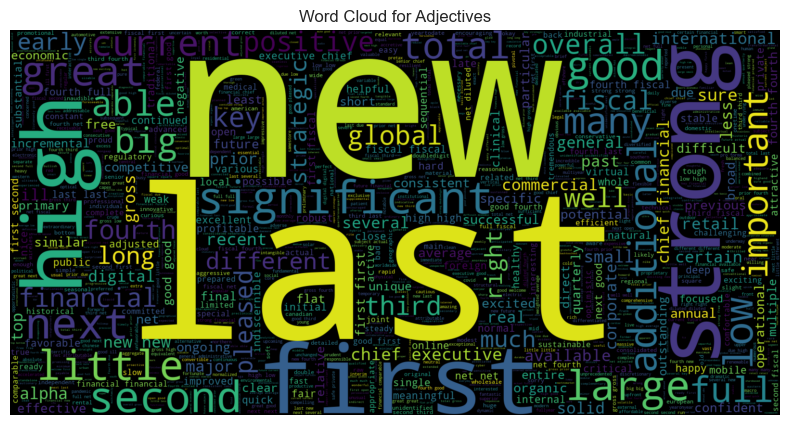

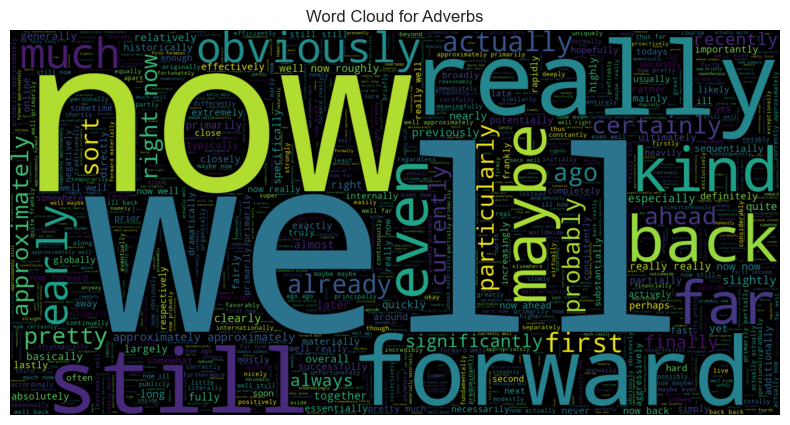

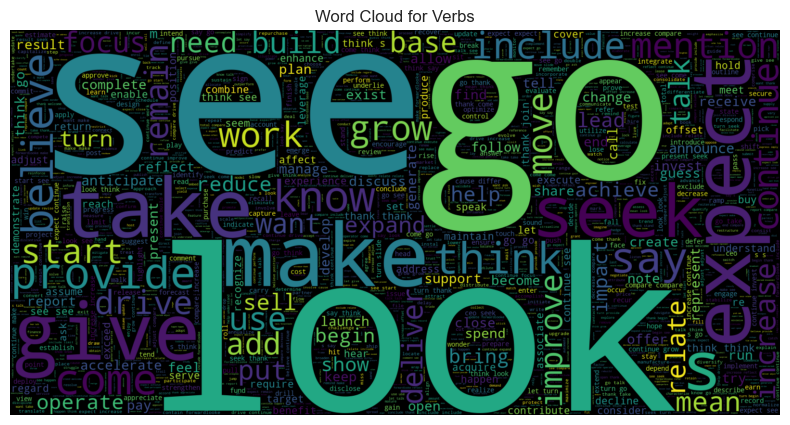

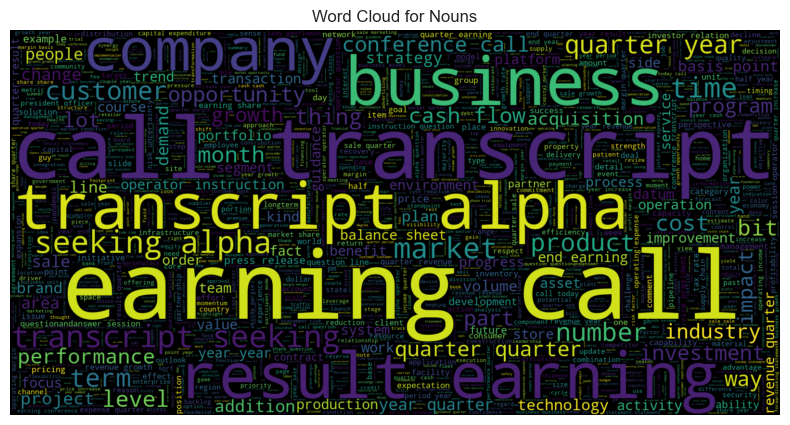

In [11]:
# Load the spaCy medium-sized English model
nlp = spacy.load("en_core_web_md")

# Define the POS tags
pos_tags = ['ADJ', 'ADV', 'VERB', 'NOUN']
pos_names = ['Adjectives', 'Adverbs', 'Verbs', 'Nouns']

# Function to extract words of particular POS tags from a document
def extract_pos_words(text, pos_tags):
    doc = nlp(text)
    pos_words = defaultdict(list)
    for token in doc:
        if token.pos_ in pos_tags:
            pos_words[token.pos_].append(token.lemma_)
    return pos_words

# Function to process 'text' in df column using the spaCy model
def process_transcript(transcript):
    doc = nlp(transcript)
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    total_lemmas = len(lemmas)
    unique_lemmas = len(set(lemmas))
    lemma_ratio = total_lemmas / unique_lemmas if unique_lemmas > 0 else 0
    return lemmas, total_lemmas, unique_lemmas, lemma_ratio

# Function to create and display a word cloud
def display_wordcloud(words, title):
    word_string = ' '.join(words)
    wc = WordCloud(max_words=5000, width=1600, height=800, background_color='black')
    wc.generate(word_string)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=12)
    plt.axis('off')
    plt.show()

# Initialize a dictionary to hold all words for each POS
all_pos_words = defaultdict(list)

# Iterate through each document in the 'text' column for POS words extraction
for text in df['text']:
    pos_words = extract_pos_words(text, pos_tags)
    for pos, words in pos_words.items():
        all_pos_words[pos] += words

# Create and display the word clouds for each POS category
for pos_tag, pos_name in zip(pos_tags, pos_names):
    display_wordcloud(all_pos_words[pos_tag], f'Word Cloud for {pos_name}')

# Apply the function to each transcript in the 'text' column for lemma processing
df_lemmas = df.copy()
df_lemmas[['lemmas', 'total_lemmas', 'unique_lemmas', 'lemma_ratio']] = df_lemmas['text'].apply(lambda x: pd.Series(process_transcript(x)))

*The word clouds above show that adjectives are the most useful in identifying sentiment related to company bankruptcy. This aligns with much research suggesting adjectives are key in sentiment analysis. However, due to limited data, an adjective-based feature space could be too sparse for the analysis.* 

*The code below displays the new dataframe (df_lemmas) comprising columns with lemma-based features (see definitions below). Subsequent statistical analyses will be conducted on these features to determine if they reveal significant differences, potentially enhancing the model when used as features.*

*New lemma-based columns include:*

*- **Average Length**: This refers to the average length of the transcripts, determined by counting the number of lemmas in each transcript.*

*- **Average Vocab Size**: Vocab size is the size of the vocabulary, represented by the total count of unique lemmas across all transcripts.*

*- **Average Diversity**: Diversity is a measure of how varied the language used in the transcripts is. It's calculated by dividing the total number of lemmas by the number of unique lemmas. A higher number indicates more frequent repetition of words.*

In [12]:
# View the dataframe with new columns of lemma statistics 
df_lemmas.sample(n=5, random_state=42)

title  \
753  Itron, Inc. (ITRI) Q1 2009 Earnings Call Trans...   
519  The Williams Companies, Inc. (NYSE:WMB) 2020 W...   
210  Ashford Hospitality Trust (NYSE:AHT) Q4 2007 E...   
943  Comfort Systems USA Q4 2007 Earnings Call Febr...   
915  PHH Corp. (NYSE:PHH) Q4 2007 Earnings Call Feb...   

                                                  text  label     sentiment  \
753  steve sanders stephens inc. john quealy canacc...      0  Non-Bankrupt   
519  praneeth satish okay good afternoon. and thank...      1      Bankrupt   
210  harry sullivan senior vice president and princ...      0  Non-Bankrupt   
943  matt duncan stephens inc david yuschak smh cap...      0  Non-Bankrupt   
915  jordan hymowitz philadelphia financial gabriel...      1      Bankrupt   

                                                lemmas  total_lemmas  \
753  [steve, sanders, stephens, inc, john, quealy, ...          5125   
519  [praneeth, satish, okay, good, afternoon, and,...          5458   
210  [harry, sullivan, senior, vice, president, and...          5047   
943  [matt, duncan, stephens, inc, david, yuschak, ...          5187   
915  [jordan, hymowitz, philadelphia, financial, ga...          5392   

     unique_lemmas  lemma_ratio  
753            992     5.166331  
519            872     6.259174  
210            970     5.203093  
943            899     5.769744  
915            888     6.072072

In [18]:
# Code to calculate statistics on word lemmas
def calculate_lemma_statistics(df):
    # Group the data by the 'sentiment' column and calculate mean for the relevant columns
    stats = df.groupby('sentiment')[['total_lemmas', 'unique_lemmas', 'lemma_ratio']].mean()

    # Rename columns for clarity
    stats = stats.rename(columns={
        'total_lemmas': 'Average Length',
        'unique_lemmas': 'Average Vocab Size',
        'lemma_ratio': 'Average Diversity'
    })

    # Rename the index for clarity in output
    stats.index.name = 'Class'
    
    return stats

# Calculate statistics for each class and display the results
stats = calculate_lemma_statistics(df_lemmas)
print("Lemma Statistics by Sentiment Class:")
stats

Lemma Statistics by Sentiment Class:


Average Length  Average Vocab Size  Average Diversity
Class                                                              
Bankrupt         4749.157556          890.951768           5.342246
Non-Bankrupt     4672.939007          879.822695           5.314187

*The average length of the transcripts, determined by counting the number of lemmas in each transcript, is seen to be more for the bankrupt companies than the non-bankrupt companies. This could be because bankruptcy situations are complex, requiring detailed explanations about finances, laws, and operations. Additionally, companies in bankruptcy might be under more rules and need to give thorough details during their earnings calls, leading to transcripts with broader vocabulary sizes. Also, companies in financial distress often repeat key points to underscore transparency and shape stakeholder perceptions, which could lead to a higher frequency of word repetition. Based on these insights, the lemma-based features will be utilized in the construction of the base models.*

*Next, various modeling techniques will be explored to identify the most suitable for the earnings call sentiment analysis. Naive Bayes, Random Forest Classifier, Support Vector Classifier (SVC), and Logistic Regression classification models have been selected because of their good performance on text data, as reported in the literature. Additionally, F1-Score, a weighted average of precision and recall, will be used to evaluate models' performances as this more useful for unbalanced classes than accuracy.*

### Model 1 - Features based on text and lemma statistics
- The base modeling strategy will focus on using lemma statistics as features, influenced by insights from the exploratory data analysis which highlighted slight differences in bankrupt and non-bankrupt transcripts.
- Model classifiers: MultinomialNB, RandomForestClassifier, SVC, LogisticRegression
- Model performance metric: F1 Score

In [19]:
# Split the data into training and test sets with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    df_lemmas['text'], 
    df_lemmas['label'], 
    train_size=0.8, 
    random_state=42, 
    stratify=df_lemmas['label']  # Ensure the distribution of classes in train and test sets mirrors the original dataset
)

# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'text' column in training data to get TF-IDF features
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Only transform the 'text' column in test data
tfidf_test = tfidf_vectorizer.transform(X_test)

# Convert the TF-IDF matrices to DataFrames
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=X_train.index)
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=X_test.index)

# Concatenate the TF-IDF features with 'total_lemmas', 'unique_lemmas', and 'lemma_ratio' from df_lemmas for both train and test
X_train_lemmas = pd.concat([tfidf_train_df, df_lemmas.loc[X_train.index, ['total_lemmas', 'unique_lemmas', 'lemma_ratio']]], axis=1)
X_test_lemmas = pd.concat([tfidf_test_df, df_lemmas.loc[X_test.index, ['total_lemmas', 'unique_lemmas', 'lemma_ratio']]], axis=1)

# Print lengths of the split data to verify the split
print(f"Length of X_train_lemmas: {len(X_train_lemmas)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_test_lemmas: {len(X_test_lemmas)}")
print(f"Length of y_test: {len(y_test)}")

# Verify the class distribution in the training and test sets
class_distribution_train = y_train.value_counts(normalize=True)
class_distribution_test = y_test.value_counts(normalize=True)

print("\nClass Distribution in Training Set:")
print(class_distribution_train)

print("\nClass Distribution in Test Set:")
print(class_distribution_test)

Length of X_train_lemmas: 812
Length of y_train: 812
Length of X_test_lemmas: 204
Length of y_test: 204

Class Distribution in Training Set:
label
0    0.69335
1    0.30665
Name: proportion, dtype: float64

Class Distribution in Test Set:
label
0    0.696078
1    0.303922
Name: proportion, dtype: float64


In [20]:
# Code to define a model pipeline (for features based on text and lemma statistics) to streamline the workflow
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = []

for classifier_name, classifier in classifiers.items():
    text_classification_pipeline = Pipeline([
        ('classifier', classifier),
    ])

    # Fit the pipeline to the training data
    text_classification_pipeline.fit(X_train_lemmas, y_train)
    
    # Predict the labels for the training and test data using the trained pipeline
    train_predicted_labels = text_classification_pipeline.predict(X_train_lemmas)
    test_predicted_labels = text_classification_pipeline.predict(X_test_lemmas)

    # Evaluate performance of the pipeline for training and test data
    train_accuracy = metrics.accuracy_score(y_train, train_predicted_labels)
    test_accuracy = metrics.accuracy_score(y_test, test_predicted_labels)
    confusion_mat = metrics.confusion_matrix(y_test, test_predicted_labels)
    classification_rep = metrics.classification_report(y_test, test_predicted_labels, zero_division=0)

    # Store results
    results.append({
        'Classifier': classifier_name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Confusion Matrix': confusion_matrix,
        'Classification Report': classification_report
    })

    print(f"\nClassifier: {classifier_name}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print("Confusion Matrix:")
    print(confusion_matrix)
    print("Classification Report:")
    print(classification_report)


Classifier: MultinomialNB
Train Accuracy: 0.6933497536945813
Test Accuracy: 0.696078431372549
Confusion Matrix:
[[142   0]
 [ 62   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       142
           1       0.00      0.00      0.00        62

    accuracy                           0.70       204
   macro avg       0.35      0.50      0.41       204
weighted avg       0.48      0.70      0.57       204


Classifier: RandomForestClassifier
Train Accuracy: 0.9741379310344828
Test Accuracy: 0.7352941176470589
Confusion Matrix:
[[136   6]
 [ 48  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83       142
           1       0.70      0.23      0.34        62

    accuracy                           0.74       204
   macro avg       0.72      0.59      0.59       204
weighted avg       0.73      0.74      0.68       204


Classifier: SVC
T

*Three of the models have little to no success in predicting bankruptcy based solely on transcripts' lemmas and their statistics. Only the Random Forest Classifier was able to weakly predict bankrupt companies with F1-score of 34%. This struggle to predict bankruptcy might come from the limited size of the data, suggesting that the available information may not fully capture the complexities or distinguishing features needed for effective prediction based on lemmas in the transcripts.*

### Model 2 - Features based on text only (no hyperparameter tuning)
- The next approach will be to model using solely the 'text' column as the feature. This might offer a more general perspective compared to incorporating additional features such as lemma statistics.
- Model classifiers: MultinomialNB, RandomForestClassifier, SVC, LogisticRegression
- Model performance metric: F1 Score; AUC Score

In [12]:
# Split the data into training and test sets with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], 
    df['label'], 
    train_size=0.8, 
    random_state=42, 
    stratify=df['label']  # Ensure the distribution of classes in train and test sets mirrors the original dataset
)

# Print lengths of the split data to verify the split
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

# Verify the class distribution in the training and test sets
class_distribution_train = y_train.value_counts(normalize=True)
class_distribution_test = y_test.value_counts(normalize=True)

print("\nClass Distribution in Training Set:")
print(class_distribution_train)

print("\nClass Distribution in Test Set:")
print(class_distribution_test)

Length of X_train: 812
Length of y_train: 812
Length of X_test: 204
Length of y_test: 204

Class Distribution in Training Set:
label
0    0.69335
1    0.30665
Name: proportion, dtype: float64

Class Distribution in Test Set:
label
0    0.696078
1    0.303922
Name: proportion, dtype: float64



Classifier: MultinomialNB
Train Accuracy: 0.9507389162561576
Test Accuracy: 0.7450980392156863
Confusion Matrix:
[[137   5]
 [ 47  15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       142
           1       0.75      0.24      0.37        62

    accuracy                           0.75       204
   macro avg       0.75      0.60      0.60       204
weighted avg       0.75      0.75      0.70       204


Classifier: RandomForestClassifier
Train Accuracy: 0.9729064039408867
Test Accuracy: 0.7450980392156863
Confusion Matrix:
[[138   4]
 [ 48  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.97      0.84       142
           1       0.78      0.23      0.35        62

    accuracy                           0.75       204
   macro avg       0.76      0.60      0.60       204
weighted avg       0.75      0.75      0.69       204


Classifier: SVC


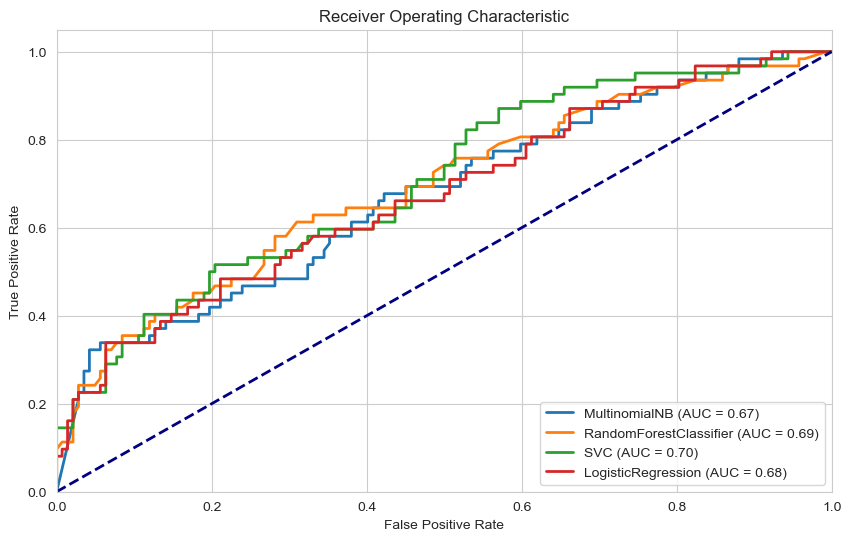

In [13]:
# Define classifiers with adjustments as needed (e.g., probability for SVC)
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

results = []
plt.figure(figsize=(10, 6))  # Prepare figure for plotting ROC curves

for classifier_name, classifier in classifiers.items():
    # Define a pipeline for each classifier
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('binarizer', Binarizer()),
        ('classifier', classifier),
    ])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Predictions
    train_predicted_labels = pipeline.predict(X_train)
    test_predicted_labels = pipeline.predict(X_test)

    # Performance evaluation
    train_accuracy = accuracy_score(y_train, train_predicted_labels)
    test_accuracy = accuracy_score(y_test, test_predicted_labels)
    conf_mat = confusion_matrix(y_test, test_predicted_labels)
    classif_report = classification_report(y_test, test_predicted_labels)

    # Store results
    results.append({
        'Classifier': classifier_name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Confusion Matrix': conf_mat,
        'Classification Report': classif_report
    })

    print(f"\nClassifier: {classifier_name}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print("Confusion Matrix:")
    print(conf_mat)
    print("Classification Report:")
    print(classif_report)
    
    # ROC curve plotting
    if hasattr(classifier, "predict_proba"):
        probas_ = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(classifier, "decision_function"):
        probas_ = pipeline.decision_function(X_test)
    else:
        continue  # Skip if neither is available
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classifier_name} (AUC = {roc_auc:.2f})')

# Finalize ROC curve plot
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

*The four classifiers tested - MultinomialNB, RandomForestClassifier, SVC, and LogisticRegression - demonstrated similar test accuracies around 74.5-75.5%. However, each model showed potential overfitting due to higher training accuracies.*

*- MultinomialNB and RandomForestClassifier were more effective at identifying non-bankrupt companies but struggled with correctly predicting bankrupt ones, with slightly better recall for class 1 (bankrupt) in MultinomialNB.* 

*-SVC, while having lower training accuracy, also showed low recall for bankrupt companies.* 

*-LogisticRegression outperformed in generalization with the highest test accuracy and better recall for bankrupt companies, making it the most effective at balancing identification across classes.*

### Model 3 - SMOTE - Features based on text only (no hyperparameter tuning)
- The next step is to implement SMOTE, while maintaining the same feature set as the previous model, to assess if there's an enhancement in performance.
- Model classifiers: MultinomialNB, RandomForestClassifier, SVC, LogisticRegression
- Model performance metric: F1 Score

In [14]:
# Confirming initial class distribution before applying SMOTE
print("Before SMOTE:", Counter(y_train))

Before SMOTE: Counter({0: 563, 1: 249})


In [15]:
# X_train and y_train are defined and contain training data and labels
# Vectorize text data
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Apply SMOTE to the vectorized text data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vect, y_train)

print("After SMOTE:", Counter(y_train_resampled))

After SMOTE: Counter({0: 563, 1: 563})


In [16]:
# Code to implement SMOTE for oversampling
# Create a pipeline to streamline the workflow
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = []

for classifier_name, classifier in classifiers.items():
    # Create a new pipeline for each classifier, without resampling as it's already done
    classifier_pipeline = Pipeline([
        # Vectorization is done, hence skipping straight to classification
        ('classifier', classifier),
    ])
    
    # Fit the classifier to the resampled training data
    classifier_pipeline.fit(X_train_resampled, y_train_resampled)
    
    # Predict the labels for the resampled training data and original test data
    train_predicted_labels = classifier_pipeline.predict(X_train_resampled)
    test_predicted_labels = classifier_pipeline.predict(X_test_vect)

    # Evaluate and print the performance
    train_accuracy = accuracy_score(y_train_resampled, train_predicted_labels)
    test_accuracy = accuracy_score(y_test, test_predicted_labels)
    confusion_mat = confusion_matrix(y_test, test_predicted_labels)
    classification_rep = classification_report(y_test, test_predicted_labels)

    # Store results
    results.append({
        'Classifier': classifier_name,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Confusion Matrix': confusion_mat,
        'Classification Report': classification_rep
    })

    print(f"\nClassifier: {classifier_name}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")
    print("Confusion Matrix:")
    print(confusion_mat)
    print("Classification Report:")
    print(classification_rep)


Classifier: MultinomialNB
Train Accuracy: 0.8907637655417406
Test Accuracy: 0.5637254901960784
Confusion Matrix:
[[63 79]
 [10 52]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.44      0.59       142
           1       0.40      0.84      0.54        62

    accuracy                           0.56       204
   macro avg       0.63      0.64      0.56       204
weighted avg       0.72      0.56      0.57       204


Classifier: RandomForestClassifier
Train Accuracy: 0.9813499111900533
Test Accuracy: 0.7303921568627451
Confusion Matrix:
[[135   7]
 [ 48  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       142
           1       0.67      0.23      0.34        62

    accuracy                           0.73       204
   macro avg       0.70      0.59      0.58       204
weighted avg       0.72      0.73      0.68       204


Classifier: SVC
Trai

*SMOTE (Synthetic Minority Over-sampling Technique) summary:* 

*-MultinomialNB, despite a decent training accuracy (89.08%), falters severely on test data with an accuracy of 56.37%, highlighting overfitting issues. Notably, it achieves an F1 score of 0.54 for the minority class, showcasing a strength in identifying this class with a high recall of 84%.*

*-RandomForestClassifier shows a better balance between training (98.13%) and test accuracy (73.04%), yet its F1 score for the minority class drops to 0.34, underpinned by a low recall rate of 23%. This indicates a struggle in effectively identifying minority class instances.*

*-SVC improves test accuracy to 75.49% with a slightly higher F1 score of 0.39 for class 1, but its recall of 26% still points to difficulties in recognizing minority class samples.*

*-LogisticRegression offers a compromise with a 74.51% test accuracy and a modest F1 score of 0.51 for the minority class. It achieves a better recall of 44%, suggesting a more balanced approach towards both classes compared to the other models.*

*The analysis incorporating SMOTE was conducted to align with methodologies from the influencing research paper. However, SMOTE's application in the final model will be excluded. This approach revealed a potential correlation: the model's ability to detect bankrupt classes may improve with more comprehensive training data. This insight suggests the value of balanced datasets for enhancing predictive accuracy in identifying critical, underrepresented classes.*

### Model 4 - K-Fold CV - Features based on text only (no hyperparameter tuning)
- To comprehensively evaluate the classifiers' performances across the entire dataset, k-fold cross-validation with the same feature set will be implemented.
- Model classifiers: MultinomialNB, RandomForestClassifier, SVC, LogisticRegression
- Model performance metric: F1 Score

In [15]:
# Code to run k-fold cross validation
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = []
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
texts_cv = df['text'].values  
labels_cv = df['label'].values 

for classifier_name, classifier in classifiers.items():
    text_classification_pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()), # Experimented with ngram_range=(1, 2) and (1, 3) but got worse performances
        ('binarizer', Binarizer()),
        ('classifier', classifier),
    ])

    fold_train_accuracies = []
    fold_test_accuracies = []
    fold_predictions = []
    fold_true_labels = []  # Store true labels for each fold
    
    for train_idx, test_idx in kf.split(texts_cv):  
        X_train_cv, X_test_cv = texts_cv[train_idx], texts_cv[test_idx]  
        y_train_cv, y_test_cv = labels_cv[train_idx], labels_cv[test_idx] 

        # Fit the pipeline to the training data
        text_classification_pipeline.fit(X_train_cv, y_train_cv)

        # Predict and evaluate on the training set
        train_predicted_labels = text_classification_pipeline.predict(X_train_cv)
        train_accuracy = accuracy_score(y_train_cv, train_predicted_labels)
        fold_train_accuracies.append(train_accuracy)

        # Predict and evaluate on the test set
        test_predicted_labels = text_classification_pipeline.predict(X_test_cv)
        test_accuracy = accuracy_score(y_test_cv, test_predicted_labels)
        fold_test_accuracies.append(test_accuracy)
        fold_predictions.extend(test_predicted_labels)
        fold_true_labels.extend(y_test_cv)  # Add true labels for confusion matrix and classification report

    # Aggregate results
    average_train_accuracy = np.mean(fold_train_accuracies)
    average_test_accuracy = np.mean(fold_test_accuracies)
    conf_matrix = confusion_matrix(fold_true_labels, fold_predictions)
    classif_report = classification_report(fold_true_labels, fold_predictions)

    # Store results
    results.append({
        'Classifier': classifier_name,
        'Average Train Accuracy': average_train_accuracy,
        'Average Test Accuracy': average_test_accuracy,
        'Confusion Matrix': conf_matrix,
        'Classification Report': classif_report
    })

    print(f"\nClassifier: {classifier_name}")
    print(f"Average Train Accuracy: {average_train_accuracy:.2f}")
    print(f"Average Test Accuracy: {average_test_accuracy:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classif_report)


Classifier: MultinomialNB
Average Train Accuracy: 0.95
Average Test Accuracy: 0.74
Confusion Matrix:
[[671  34]
 [234  77]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       705
           1       0.69      0.25      0.36       311

    accuracy                           0.74      1016
   macro avg       0.72      0.60      0.60      1016
weighted avg       0.73      0.74      0.69      1016


Classifier: RandomForestClassifier
Average Train Accuracy: 0.97
Average Test Accuracy: 0.73
Confusion Matrix:
[[675  30]
 [242  69]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83       705
           1       0.70      0.22      0.34       311

    accuracy                           0.73      1016
   macro avg       0.72      0.59      0.58      1016
weighted avg       0.72      0.73      0.68      1016


Classifier: SVC
Average Train Accuracy: 

*The Logistic Regression model again outperforms all the other models based on F1 score, achieving 42% in bankruptcy prediction. This performance aligns with the findings from the earlier Model 2, which was evaluated without cross-validation. Based on this observation, Logistic Regression has been chosen for additional hyperparameter tuning. This step aims to not only enhance the model's performance further but also to address the high average training accuracy, which hints at potential overfitting. The goal is to achieve better generalization in the model's predictive capabilities.*

### Model 5 - LR - Features based on text only (with hyperparameter tuning)
- Logistic Regression has been chosen for additional hyperparameter tuning. This step aims to not only enhance the model's performance further but also to address the high average training accuracy, which hints at potential overfitting. The goal is to achieve better generalization in the model's predictive capabilities.
- Model classifier: LogisticRegression
- Model performance metric: F1 Score; AUC Score

In [16]:
# Hyperparameter tuning - GridSearchCV
# Adjust the parameter grid to apply only to LogisticRegression
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # 'liblinear' solver is suitable for small datasets and 'l1' penalty
}

# Define a single classifier pipeline with LogisticRegression
# Assuming you want to perform GridSearch only for LogisticRegression as per the param_grid
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('binarizer', Binarizer()),
    ('classifier', LogisticRegression(max_iter=1000)),
])

# Define GridSearchCV with the F1 score as the scoring metric
grid_search = GridSearchCV(pipeline, param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5, verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Best model after grid search
best_model = grid_search.best_estimator_

# Predict the labels for the training and test data using the trained best model
train_predicted_labels = best_model.predict(X_train)
test_predicted_labels = best_model.predict(X_test)

# Evaluate performance of the best model
train_accuracy = metrics.accuracy_score(y_train, train_predicted_labels)
test_accuracy = metrics.accuracy_score(y_test, test_predicted_labels)
confusion_mat = metrics.confusion_matrix(y_test, test_predicted_labels)
classification_rep = metrics.classification_report(y_test, test_predicted_labels)

# Print the best parameters and model performance
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(confusion_mat)
print("Classification Report:")
print(classification_rep)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Train Accuracy: 0.9729064039408867
Test Accuracy: 0.7549019607843137
Confusion Matrix:
[[132  10]
 [ 40  22]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       142
           1       0.69      0.35      0.47        62

    accuracy                           0.75       204
   macro avg       0.73      0.64      0.65       204
weighted avg       0.74      0.75      0.73       204



*The best hyperparameters for the Logistic Regression model were identified as `C=10`, `penalty=l2`, and `solver=liblinear`. The model achieved a high training accuracy of 97.29% but a lower test accuracy of 75.49%. The confusion matrix shows the model is better at predicting the non-bankrupt class (0), compared to the bankrupt class (1) with only 22 true positives against 40 false negatives. The classification report highlights a precision of 0.77 and a recall of 0.93 for the majority class, resulting in an F1-score of 0.84. For the minority class, precision drops to 0.69 with a recall of 0.35, leading to an F1-score of 0.47. Overall, the model has a 75% accuracy, with its performance still being significantly better in identifying the majority class than the minority class.*

In [20]:
# Hyperparameter tuning - LR with K-Fold CV - Evaluate using AUC (Area Under the Curve)
# Define the Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)

k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
input_texts = df['text'].values
input_labels = df['label'].values

text_classification_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('binarizer', Binarizer()),
    ('classifier', classifier),
])

fold_train_accuracies = []
fold_test_accuracies = []
fold_auc_scores = []
fold_true_labels = []  # Store true labels for each fold
fold_predicted_probabilities = []  # Store predicted probabilities for AUC calculation

for train_index, test_index in kf.split(input_texts):
    train_texts, test_texts = input_texts[train_index], input_texts[test_index]
    train_labels, test_labels = input_labels[train_index], input_labels[test_index]

    # Fit the pipeline to the training data
    text_classification_pipeline.fit(train_texts, train_labels)

    # Predict and evaluate on the training set
    train_predicted_labels = text_classification_pipeline.predict(train_texts)
    train_accuracy = accuracy_score(train_labels, train_predicted_labels)
    fold_train_accuracies.append(train_accuracy)

    # Predict and evaluate on the test set
    test_predicted_labels = text_classification_pipeline.predict(test_texts)
    test_accuracy = accuracy_score(test_labels, test_predicted_labels)
    test_predicted_probabilities = text_classification_pipeline.predict_proba(test_texts)[:, 1]
    fold_test_accuracies.append(test_accuracy)
    fold_true_labels.extend(test_labels)  # Add true labels for AUC calculation
    fold_predicted_probabilities.extend(test_predicted_probabilities)  # Add probabilities for AUC calculation

    # Compute AUC for this fold
    fold_auc = roc_auc_score(test_labels, test_predicted_probabilities)
    fold_auc_scores.append(fold_auc)

# Aggregate results
average_train_accuracy = np.mean(fold_train_accuracies)
average_test_accuracy = np.mean(fold_test_accuracies)
average_auc_score = np.mean(fold_auc_scores)

# Convert list to NumPy array for element-wise comparison
fold_predicted_classes = np.array(fold_predicted_probabilities) > 0.69
conf_matrix = confusion_matrix(fold_true_labels, fold_predicted_classes)
classif_report = classification_report(fold_true_labels, fold_predicted_classes)

print(f"\nClassifier: Logistic Regression")
print(f"Average Train Accuracy: {average_train_accuracy:.2f}")
print(f"Average Test Accuracy: {average_test_accuracy:.2f}")
print(f"Average AUC Score: {average_auc_score:.2f}")

# Print AUC scores for each fold
for i, auc in enumerate(fold_auc_scores, 1):
    print(f'AUC Score for Fold {i}: {auc:.2f}')

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classif_report)


Classifier: Logistic Regression
Average Train Accuracy: 0.97
Average Test Accuracy: 0.72
Average AUC Score: 0.67
AUC Score for Fold 1: 0.66
AUC Score for Fold 2: 0.60
AUC Score for Fold 3: 0.72
AUC Score for Fold 4: 0.63
AUC Score for Fold 5: 0.76
AUC Score for Fold 6: 0.63
AUC Score for Fold 7: 0.58
AUC Score for Fold 8: 0.71
AUC Score for Fold 9: 0.71
AUC Score for Fold 10: 0.68
Confusion Matrix:
[[661  44]
 [226  85]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       705
           1       0.66      0.27      0.39       311

    accuracy                           0.73      1016
   macro avg       0.70      0.61      0.61      1016
weighted avg       0.72      0.73      0.69      1016



*The Logistic Regression model shows a high training accuracy of 97% but a lower test accuracy of 72%, still hinting at overfitting. The average AUC score is 0.67, indicating moderate ability to differentiate between classes, with variability across folds (ranging from 0.58 to 0.76). The model struggles with identifying the bankrupt class, achieving only a 0.27 recall and 0.39 F1-score. Overall, the model still needs improvement in recognizing the minority class.*

### Model 6 - Model Stacking (with all classifiers)
- Model classifiers: MultinomialNB, RandomForestClassifier, SVC, LogisticRegression
- Model performance metric: F1 Score

In [23]:
# Code for model stacking
# Define the classifiers
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(probability=True),  # Enable probability for stacking
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

# Convert the classifiers dictionary to a list of tuples for StackingClassifier
classifiers_list = [(name, classifier) for name, classifier in classifiers.items()]

# Define the stacking classifier with the list of classifiers
stacked_classifier = StackingClassifier(estimators=classifiers_list, final_estimator=LogisticRegression())

# Define the pipeline with TfidfVectorizer, Binarizer, and StackingClassifier
stacked_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('binarizer', Binarizer()),
    ('classifier', stacked_classifier),
])

# Fit the pipeline to the training data
stacked_pipeline.fit(X_train, y_train)

# Predict the labels for the training and test data using the trained pipeline
train_predicted_labels = stacked_pipeline.predict(X_train)
test_predicted_labels = stacked_pipeline.predict(X_test)

# Evaluate performance of the pipeline for training and test data
train_accuracy = accuracy_score(y_train, train_predicted_labels)
test_accuracy = accuracy_score(y_test, test_predicted_labels)
conf_matrix = confusion_matrix(y_test, test_predicted_labels)
classif_report = classification_report(y_test, test_predicted_labels)

# Print results
print("\nStacked Model Results")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classif_report)


Stacked Model Results
Train Accuracy: 0.9729064039408867
Test Accuracy: 0.7450980392156863
Confusion Matrix:
[[138   4]
 [ 48  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.97      0.84       142
           1       0.78      0.23      0.35        62

    accuracy                           0.75       204
   macro avg       0.76      0.60      0.60       204
weighted avg       0.75      0.75      0.69       204



*The Stacked Model achieved a F1-score of 0.35 for class 1 (bankrupt companies), with a precision of 0.78 and a recall of 0.23, indicating limited effectiveness in predicting bankruptcy accurately.*

### Model Summary
- Plot of all the models' performances
- Confusion matrix of the best model

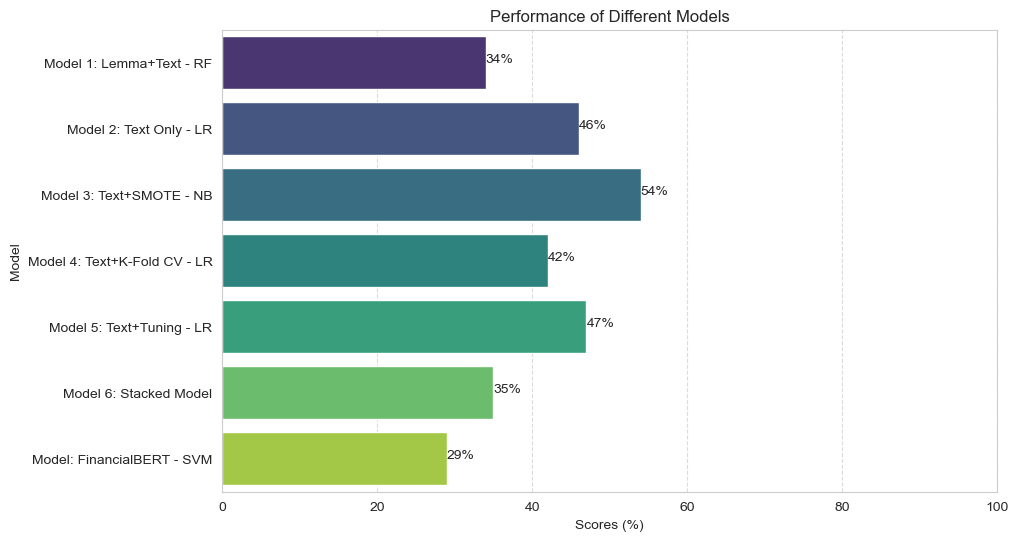

In [26]:
# Plot of model performances
# Model names and their corresponding scores
data = {
    'Model': ['Model 1: Lemma+Text - RF', 'Model 2: Text Only - LR', 
              'Model 3: Text+SMOTE - NB', 'Model 4: Text+K-Fold CV - LR',
              'Model 5: Text+Tuning - LR', 'Model 6: Stacked Model',
              'Model: FinancialBERT - SVM'],
    'Scores': [34, 46, 54, 42, 47, 35, 29]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(y='Model', x='Scores', data=df, hue='Model', palette='viridis')
plt.xlabel('Scores (%)')
plt.title('Performance of Different Models')
plt.xlim(0, 100)  # Set the x limits to be from 0 to 100
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the scores on the bars
for index, value in enumerate(df['Scores']):
    plt.text(value, index, str(value) + '%')

plt.show()

*Based on the provided data, the performance of various models in a sentiment analysis project aimed at bankruptcy prediction is summarized as follows:*

*- **Model 1: Lemma+Text - RF (Random Forest)** achieves an F1-score of 34%, suggesting moderate effectiveness in utilizing both lemma statistics and text for prediction. The model's reliance on Random Forest indicates it might struggle with the complexity of textual data.*

*- **Model 2: Text Only - LR (Logistic Regression)** scores an F1-score of 46%, showing improved performance over Model 1. This model benefits from the simplicity and direct focus on text data, enhancing its predictive accuracy.*

*- **Model 3: Text+SMOTE - NB (Naive Bayes)** records an F1-score of 54%, the highest among the listed models. The use of SMOTE to balance the dataset likely contributes to the Naive Bayes model's enhanced ability to predict bankruptcy from text data.*

*- **Model 4: Text+K-Fold CV - LR** has an F1-score of 42%, indicating that incorporating K-Fold Cross-Validation with Logistic Regression on text data provides reliable, though not outstanding, performance.*

*- **Model 5: Text+Tuning - LR** improves slightly to an F1-score of 47%, showing that hyperparameter tuning on a Logistic Regression model can enhance predictive accuracy marginally beyond the basic text-only approach.*

*- **Model 6: Stacked Model** yields an F1-score of 35%, suggesting that despite the complexity and potential of stacked modeling techniques, it does not significantly outperform simpler models in this context.*

*- **Model: FinancialBERT - SVM (Support Vector Machine)**, completed on Google Colab and not included in the Jupyter notebook for direct comparison, shows an F1-score of 29%. This result indicates that the FinancialBERT approach combined with SVM falls short in performance relative to other models, possibly due to the challenges of adapting BERT embeddings effectively with SVM for this specific task.*

*Overall, the models leveraging text data with or without additional processing or balancing techniques like SMOTE exhibit varied effectiveness in predicting bankruptcy. The Naive Bayes model with SMOTE stands out for its higher F1-score, suggesting that balancing class distribution and focusing on text data are crucial for improving model performance in this application. However, more complex or computationally intensive models like the Stacked Model and FinancialBERT with SVM do not necessarily translate to better predictive accuracy in this context.*

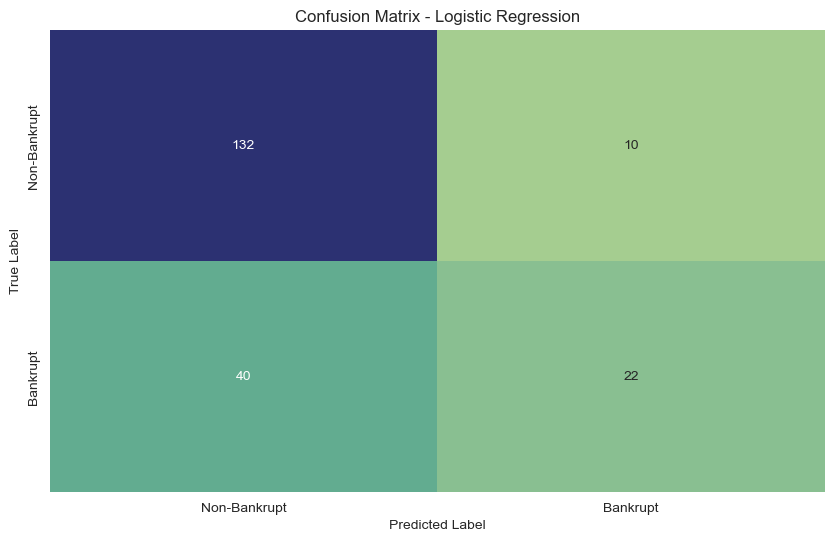

In [28]:
# Confusion matrix - Model 5 - LR - Features based on text only (with hyperparameter tuning) 
conf_matrix = np.array([[132, 10], [40, 22]])

# Define class labels
class_names = ['Non-Bankrupt', 'Bankrupt']

# Create a DataFrame from the confusion matrix array
confusion_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plotting
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='crest', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

*The confusion matrix reveals that the model correctly predicted 132 instances as 'Non-Bankrupt' (True Positives) and 22 instances as 'Bankrupt' (True Negatives). However, there were 10 instances where 'Non-Bankrupt' cases were incorrectly predicted as 'Bankrupt' (False Positives), and 40 instances where 'Bankrupt' cases were incorrectly predicted as 'Non-Bankrupt' (False Negatives). This indicates that while the model is relatively good at identifying 'Non-Bankrupt' cases, it struggles more with accurately identifying 'Bankrupt' cases, as seen in the higher number of False Negatives compared to False Positives.*

### Sentiment Analysis Summary
- Review
- Challenges
- Conclusion
- Recommendation
- References

#### Review

*The sentiment analysis project aims to enhance bankruptcy prediction by integrating traditional financial data with sentiment analysis from earnings call transcripts. The project's goals are to craft a smarter framework for bankruptcy prediction, decode emotions where numerical data falls short, and provide stakeholders with data-driven insights to avoid financial pitfalls. The dataset, sourced from Seeking Alpha, comprises earnings call transcripts, predominantly from non-bankrupt firms, and requires text pre-processing for NLP analysis.*

*Initial exploratory data analysis (EDA) and pre-processing steps, including converting text to lowercase and removing extraneous elements, set the stage for deeper linguistic analysis. Despite similar word clouds for both bankrupt and non-bankrupt firms, further text processing aims to uncover distinctive terms. The analysis explores part-of-speech tags and lemmas, revealing adjectives as crucial for sentiment analysis, although data limitations may restrict the effectiveness of an adjective-based feature space.*

*Lemma-based features, such as average transcript length, vocabulary size, and diversity, show potential for modeling, with bankrupt companies' transcripts being longer and possibly more complex. However, base modeling with Naive Bayes, Random Forest Classifier, SVC, and Logistic Regression, focusing on lemma statistics, struggled to predict bankruptcy effectively, except for a modest F1-score from the Random Forest Classifier.*

*Subsequent modeling directly using the 'text' column and incorporating SMOTE for balancing suggested that logistic regression, adjusted via hyperparameter tuning, holds promise for better generalization and bankruptcy prediction. Despite challenges, including potential overfitting indicated by high training accuracies, logistic regression emerged as a potential candidate for further optimization to improve bankruptcy prediction based on sentiment analysis.*

#### Challenges

*The performance of the models may be constrained by several factors, including the limited size of the dataset, its imbalanced nature, and the potential use of auto-generated transcripts.*

#### Conclusion
*The analysis suggests that the current methodology should primarily serve as an adjunct to models based on numerical financial data due to:*

*- High training accuracies across all models, indicating a risk of overfitting and consequently weak generalization capabilities.*

*-F1-scores not exceeding 70%, falling short of the benchmark for a robust data science model.*

#### Recommendation

*To potentially elevate model performance, consider the following strategies:*

*-Implementing hybrid models that integrate BERT with deep learning architectures could enhance the model's understanding of complex textual data.*

*-Enriching the dataset with reliable text data and augmenting it with audio and video data may provide a more comprehensive basis for analysis.*

*-Incorporating numerical financial data to extract relevant ratios and indicators could offer a more holistic view of a company's financial health.*

#### References
- Siddiqui, H.U.R., de Abajo, B.S., Díez, I.T., Rustam, F., Raza, A., Atta, S., & Ashraf, I. (2023). Predicting bankruptcy of firms using earnings call data and transfer learning. PeerJ Computer Science, 9, e1134. https://doi.org/10.7717/peerj-cs.1134. PMID: 37346732; PMCID: PMC10280182.
  - Kochmar, E. (2022). Getting Started with Natural Language Processing. "Sentiment analyser using sentiment lexicons." pp. 229-303.

- DataRobot. Using Machine Learning for Sentiment Analysis: a Deep Dive. Retrieved from https://www.datarobot.com/blog/using-machine-learning-for-sentiment-analysis-a-deep-dive/

- Journal of Big Data. (n.d.). Sentiment analysis classification system using hybrid BERT models. Retrieved from https://journalofbigdata.springeropen.com/articles/10.1186/s40537-023-00781-w
78-w


### End of Analysis